# Case: diff_1ok_inv_diff_from_mob

Gradient verification for the 1D diffusion case with 1st order kinetics tracer mineral dissolution. Inversion of diffusion coefficient.

The goal here is to verify the correctness of the adjoint state method in HYTEC by comparing the results with the demonstrator's which are considered as correct.

In [1]:
import os
from pathlib import Path
import logging
import copy
from typing import Iterable
import pyrtid
import pyrtid.forward as dmfwd
import pyrtid.inverse as dminv
import nested_grid_plotter as ngp
import matplotlib.pyplot as plt
from matplotlib.animation import HTMLWriter
from IPython.display import HTML
import numpy as np
import scipy as sp
import gstools as gs
from pyrtid.utils import (
    NDArrayFloat,
    NDArrayInt,
    gen_random_ensemble,
    node_number_to_indices,
)
from scipy.interpolate import interp1d

gs.config.USE_RUST = True  # Use the rust implementation of gstools

- Set-up logging level

In [2]:
logger = logging.getLogger()
logger.setLevel(logging.INFO)
logging.info("this is a logging test")

INFO:root:this is a logging test


- Check package/software versions

In [3]:
pyrtid.utils.show_versions(logger)

INFO:root:Current version = 0.1.0

INFO:root:Used packages version:

INFO:root:iterative_ensemble_smoother = 0.1.1
INFO:root:gstools                     = 1.5.1
INFO:root:matplotlib                  = 3.9.0
INFO:root:nested_grid_plotter         = 2.0.0
INFO:root:numdiftools                 = 0.9.41
INFO:root:numpy                       = 1.26.0
INFO:root:pyesmda                     = 0.4.3
INFO:root:lbfgsb                      = 0.1.1
INFO:root:scipy                       = 1.14.1
INFO:root:sksparse                    = 0.4.15
INFO:root:stochopy                    = 2.3.0


- Create a directory to store the exported figures

In [4]:
ipynb_path = os.path.dirname(os.path.realpath("__file__"))
fig_save_path = Path(ipynb_path, "exported_figures")
fig_save_path.mkdir(parents=True, exist_ok=True)  # make sure that the directory exists

- Apply default configuration for the plots

In [5]:
pyrtid.plot.apply_default_rc_params()

## Forward problem

- Define a very simple pure diffusion case in 1D.

In [6]:
# Geometry
nx = 20  # number of voxels along the x axis
ny = 1  # number of voxels along the y axis
dx = 5.9  # voxel dimension along the x axis
dy = 9.26  # voxel dimension along the y axis
dz = 1.62  # voxel dimension along the z axis

# Time
duration_in_d = 20  # duration in days
duration_in_s = duration_in_d * 3600 * 24
dt_init = 3600 * 3  # timestep in seconds
dt_max = dt_init * 2
dt_min = dt_init / 2

# Hydro parameters
D0 = 1e-4  # general initial diffusion coefficient [m2/s]
k0 = 1e-5  # general permeability
w0 = 0.23  # general porosity [fraction]
# Chemistry parameters
c0 = 1e-10  # general initial concentration [molal]
c1 = 1e-3  # molal
M0 = 0.001  # mineral grade [mol/kg] -> kg of water
kv = -3e-4  # kinetic rate,       [mol/m2/s]
moleweight = 270.0  # molar weight [g/mol]
surface = 500  # cm2/g
As = moleweight * surface / 1e4  # specific area [m2/mol]
logK = 2
Ks = 1.0 / pow(10, logK)  # solubility constant [no unit]
stocoef = 5.0

crank_diff = 0.85

# Values for the x axis ()meters
x_positions_in_meters = np.arange(nx) * dx + dx / 2

- Five observation wells

In [7]:
observation_locations = [2, 6, 10, 14, 18]

- Create an initial "bumped" reference distribution for the diffusion, and a flat one for the initial estimation.

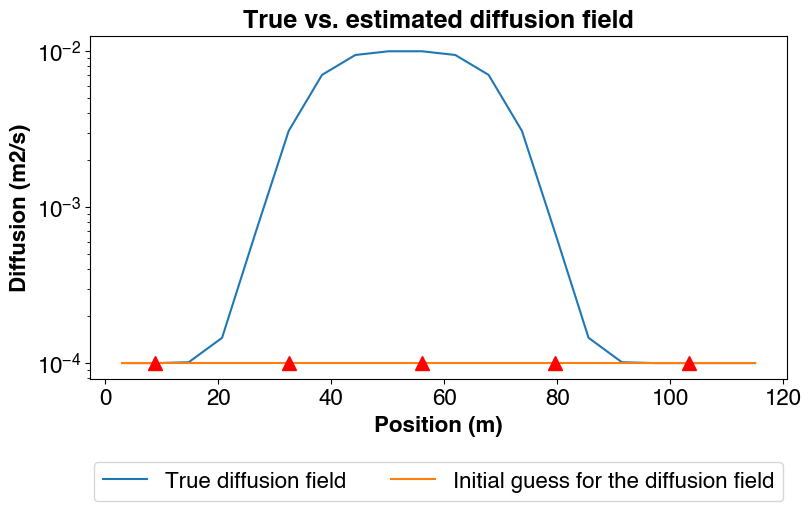

In [8]:
diffusion_reference: NDArrayFloat = np.ones(nx) * D0
diffusion_reference[6:12] = 1e-2
diffusion_reference = sp.ndimage.gaussian_filter(diffusion_reference, sigma=1)

# Estimated diffusion
diffusion_estimated: NDArrayFloat = np.ones(nx) * D0

plotter = ngp.NestedGridPlotter(plt.figure(figsize=(8, 5)))
ax = plotter.ax_dict["ax1-1"]
ax.plot(x_positions_in_meters, diffusion_reference, label="True diffusion field")
ax.plot(
    x_positions_in_meters,
    diffusion_estimated,
    label="Initial guess for the diffusion field",
)
ax.set_xlabel("Position (m)", weight="bold")
ax.set_ylabel("Diffusion (m2/s)", weight="bold")
ax.set_yscale("log")
ax.legend(loc="center", bbox_to_anchor=(0.5, -0.3), ncol=2)
ax.set_title("True vs. estimated diffusion field")
plotter.fig.set_facecolor("w")

# Add some vertical lines to indicate the well
for well_pos in observation_locations:
    ax.plot(
        well_pos * dx - dx / 2,
        np.min((diffusion_estimated, diffusion_reference)),
        label="obs wells",
        marker="^",
        markersize=10,
        c="r",
        linestyle="none",
    )

fname = "true_vs_estimated_diffusion_field"
for format in ["png", "pdf"]:
    plotter.savefig(fig_save_path.joinpath(f"{fname}.{format}"), format=format)

The mineral grades are defined in [mol/kg]. We calculate the conversion factor to obtain ppm and perform easier mass balances.

ConvU: parameter for converting the mineral content in [mol/kg] to metal grade in [ppm]. Note that the ConvU parameter is specific to the Uranium carrier phase: here Uraninite.

$C_{Uraninite}[\frac{mol}{kg}] = convU \times T_{Uranium}[ppm]$


and


$conv_u = \frac{1.023 \times density_{rock}}{238*porosity_{rock} \times 1000}$

Note the 1.023 is the conversion factor from molar mass to molal mass in CHESS.

In [9]:
conv_u: float = 1.023 * 1.63 / (238.0 * w0 * 1000)
logging.info(f"conv_u = {conv_u:.4e}")

INFO:root:conv_u = 3.0462e-05


- Create an initial gaussian spatial distribution for the mineral

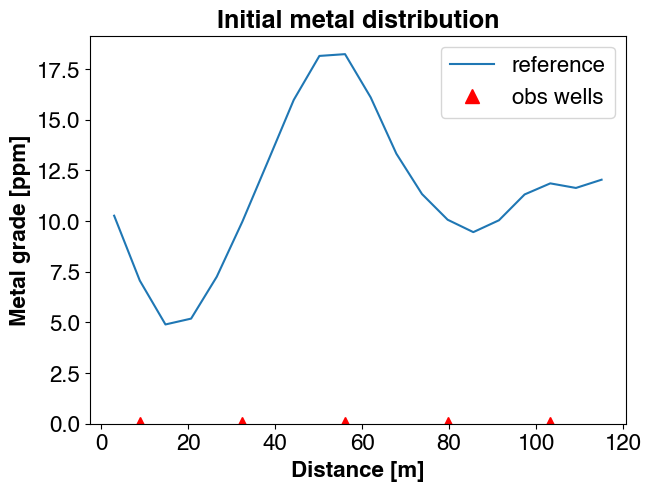

In [10]:
# Create a Gaussian Covariance Model just for the example
# To vary the results, change the seed :)
seed = 6

min_val = 2.5 * conv_u  # 10 ppm
max_val = 25 * conv_u  # 100 ppm
# Compute the mean and the standard deviation that the distribution should have so that
# <99% of the values are between min and max ~ 6 sigmas
mean = (max_val + min_val) / 2
stdev = (max_val - min_val) / 3 / 2  # std ~ 1/6 of the distribution interval
len_scale = 2.5

initial_grade = gen_random_ensemble(
    model=gs.covmodel.Gaussian,
    n_ensemble=1,
    var=stdev**2,
    len_scale=len_scale,
    mean=mean,
    nx=nx,
    ny=ny,
    seed=seed,
)[0, :, :, 0]

plotter = ngp.NestedGridPlotter()
ax = plotter.ax_dict["ax1-1"]

ax.set_xlabel("Distance [m]", fontweight="bold")
ax.set_ylabel("Metal grade [ppm]", fontweight="bold")
ax.set_ylim(0.0, float(np.max((initial_grade)) / conv_u * 1.05))
ax.set_title("Initial metal distribution", fontweight="bold")
plotter.fig.set_facecolor("w")


ax.plot(x_positions_in_meters, initial_grade / conv_u, label="reference")

# Add some vertical lines to indicate the well
for well_pos in observation_locations:
    ax.plot(
        well_pos * dx - dx / 2,
        np.min(initial_grade),
        label="obs wells",
        marker="^",
        markersize=10,
        c="r",
        linestyle="none",
    )

plotter.add_axis_legend("ax1-1")

fname = "initial_mineral_field"
for format in ["png", "pdf"]:
    plotter.savefig(fig_save_path.joinpath(f"{fname}.{format}"), format=format)

- Note: The initial concentration is null.

### Forward problem in demonstrator

In [11]:
time_params = dmfwd.TimeParameters(
    duration=duration_in_s, dt_init=dt_init, dt_min=dt_min, dt_max=dt_max
)
geometry = dmfwd.Geometry(nx=nx, ny=ny, dx=dx, dy=dx, dz=dz)
fl_params = dmfwd.FlowParameters(k0, regime=dmfwd.FlowRegime.TRANSIENT)
tr_params = dmfwd.TransportParameters(
    diffusion=D0, porosity=w0, crank_nicolson_diffusion=crank_diff, fpi_eps=1e-15
)
gch_params = dmfwd.GeochemicalParameters(
    conc=c0, conc2=c1, grade=M0, kv=kv, As=As, Ks=Ks, Ms=moleweight, stocoef=stocoef
)


# We define a function to easily generate a model.
def create_base_model() -> dmfwd.ForwardModel:
    return dmfwd.ForwardModel(geometry, time_params, fl_params, tr_params, gch_params)

- Create two models

In [12]:
model_reference = create_base_model()
model_estimate = create_base_model()
# Initial mineral grade
model_reference.tr_model.set_initial_grade(initial_grade)
model_estimate.tr_model.set_initial_grade(initial_grade)

# Diffusion fields
model_reference.tr_model.diffusion[:, 0] = diffusion_reference
model_estimate.tr_model.diffusion[:, 0] = diffusion_estimated

- Run the models

In [13]:
solver_reference = dmfwd.ForwardSolver(model_reference)
solver_reference.solve()

solver_estimate = dmfwd.ForwardSolver(model_estimate)
solver_estimate.solve()

In [14]:
(model_reference.fl_model.lu_darcy_x[0][:-1, :] * geometry.dy).shape

(20, 1)

### Comparison between hytec and the demonstrator for the forward problem

In [15]:
flux_sample_times = np.cumsum(model_estimate.time_params.ldt)

- Top view of the forward concentrations

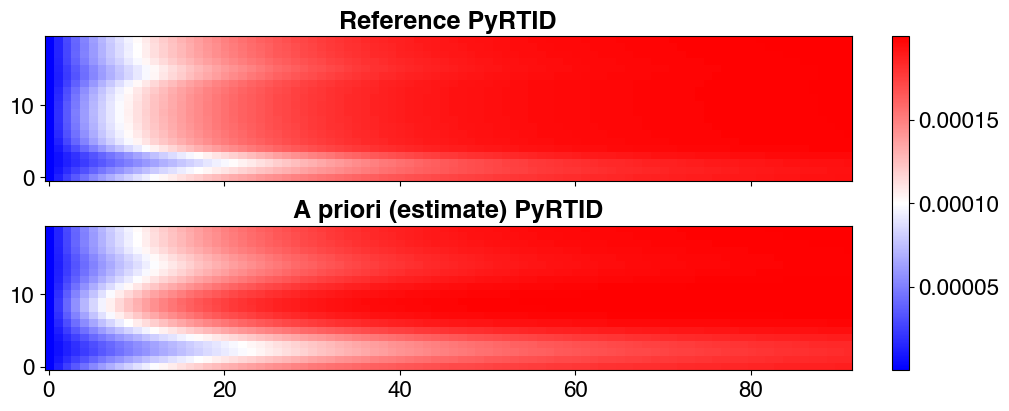

In [16]:
plotter = ngp.NestedGridPlotter(
    plt.figure(constrained_layout=True, figsize=(10, 4)),
    builder=ngp.SubplotsMosaicBuilder(
        mosaic=[["ax1-1"], ["ax2-1"]],
        sharey=True,
        sharex=True,
    ),
)

ngp.multi_imshow(
    axes=list(plotter.ax_dict.values()),
    fig=plotter.fig,
    data={
        "Reference PyRTID": model_reference.tr_model.conc[:, 0, :].T,
        "A priori (estimate) PyRTID": model_estimate.tr_model.conc[:, 0, :].T,
    },
)

fname = "tracer_concentration_true_vs_estimate_map"
for format in ["png", "pdf"]:
    plotter.savefig(fig_save_path.joinpath(f"{fname}.{format}"), format=format)

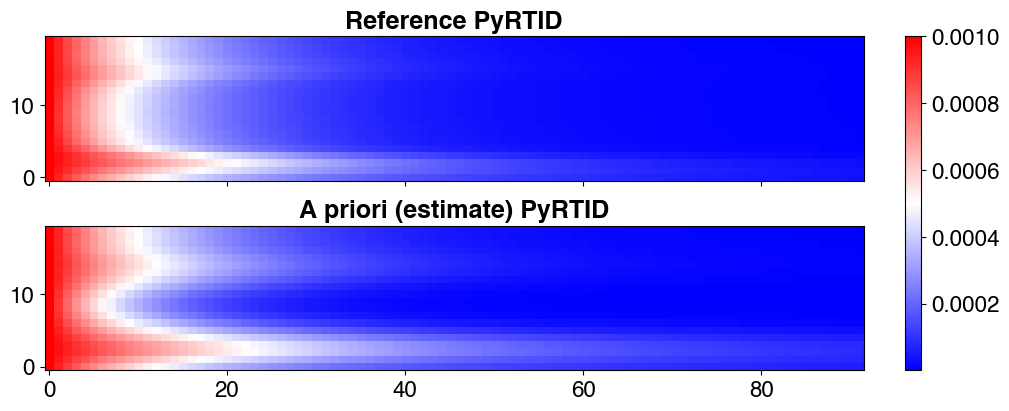

In [17]:
plotter = ngp.NestedGridPlotter(
    plt.figure(constrained_layout=True, figsize=(10, 4)),
    builder=ngp.SubplotsMosaicBuilder(
        mosaic=[["ax1-1"], ["ax2-1"]],
        sharey=True,
        sharex=True,
    ),
)

ngp.multi_imshow(
    axes=list(plotter.ax_dict.values()),
    fig=plotter.fig,
    data={
        "Reference PyRTID": model_reference.tr_model.conc2[:, 0, :].T,
        "A priori (estimate) PyRTID": model_estimate.tr_model.conc2[:, 0, :].T,
    },
)

fname = "tracer_concentration_true_vs_estimate_map"
for format in ["png", "pdf"]:
    plotter.savefig(fig_save_path.joinpath(f"{fname}.{format}"), format=format)

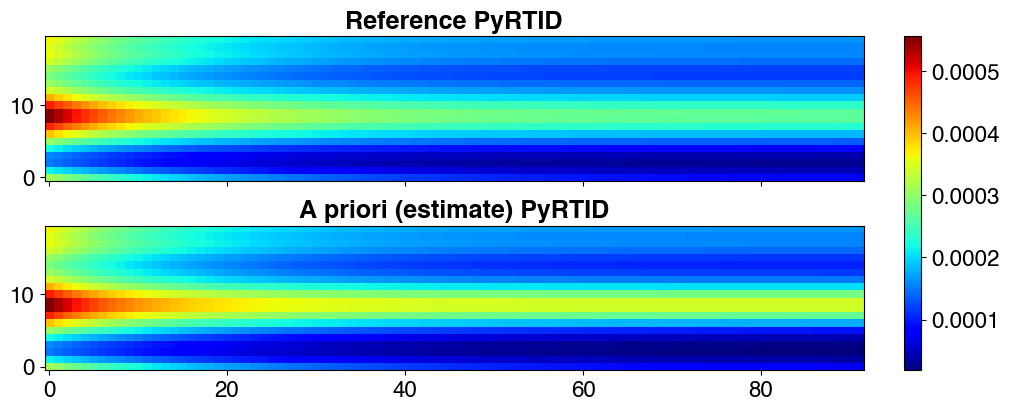

In [18]:
plotter = ngp.NestedGridPlotter(
    plt.figure(constrained_layout=True, figsize=(10, 4)),
    builder=ngp.SubplotsMosaicBuilder(
        mosaic=[["ax1-1"], ["ax2-1"]],
        sharey=True,
        sharex=True,
    ),
)

ngp.multi_imshow(
    axes=list(plotter.ax_dict.values()),
    fig=plotter.fig,
    data={
        "Reference PyRTID": model_reference.tr_model.grade[:, 0, :].T,
        "A priori (estimate) PyRTID": model_estimate.tr_model.grade[:, 0, :].T,
    },
    imshow_kwargs={"cmap": plt.get_cmap("jet")},
)

fname = "tracer_concentration_true_vs_estimate_map"
for format in ["png", "pdf"]:
    plotter.savefig(fig_save_path.joinpath(f"{fname}.{format}"), format=format)

- Forward variables at the producer locations

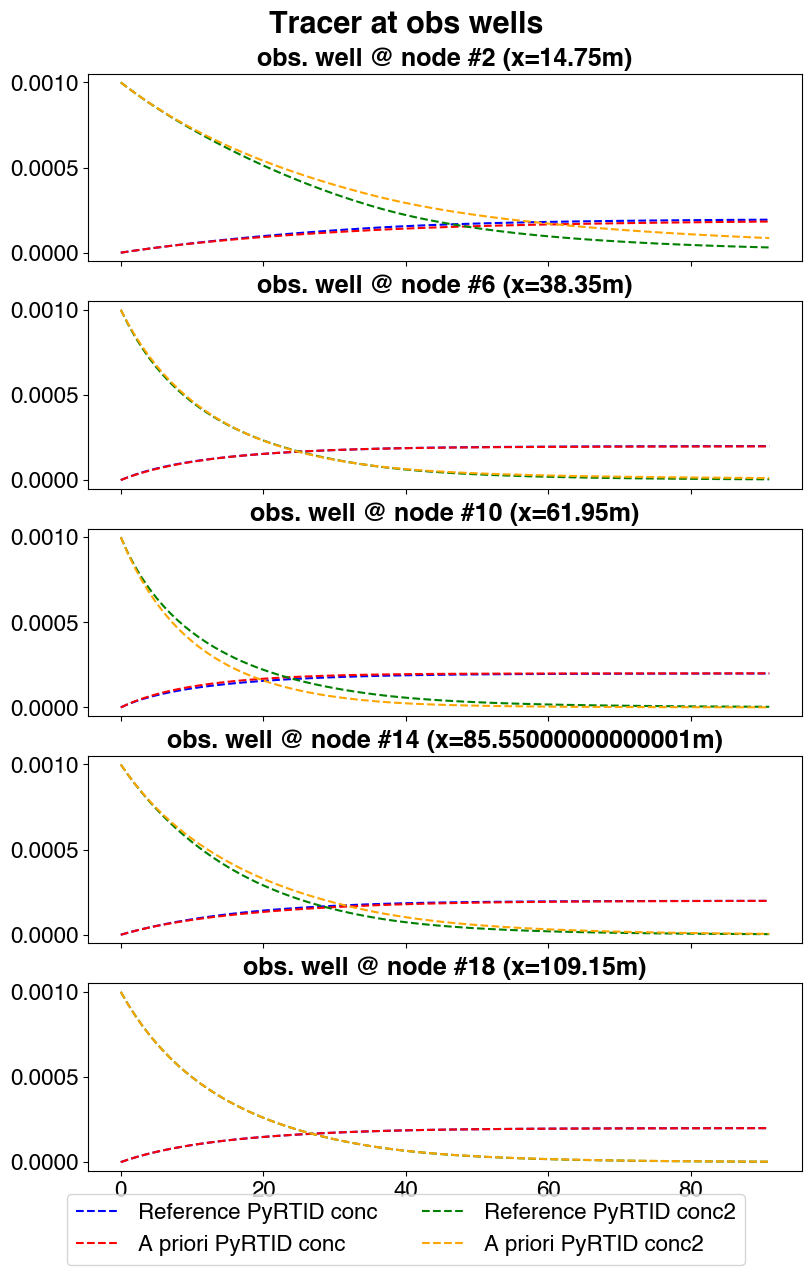

In [19]:
plotter = ngp.NestedGridPlotter(
    plt.figure(constrained_layout=True, figsize=(8, 12)),
    builder=ngp.SubplotsMosaicBuilder(
        mosaic=[["ax1-1"], ["ax2-1"], ["ax3-1"], ["ax4-1"], ["ax5-1"]],
        sharey=False,
        sharex=True,
    ),
)

for i, node_id in enumerate(observation_locations):
    ax = plotter.get_axis(f"ax{i + 1}-1")
    x = (node_id + 0.5) * geometry.dx
    obs_well_name = f"obs. well @ node #{node_id} (x={x}m)"

    ax.set_title(obs_well_name)
    ax.plot(
        model_reference.tr_model.conc[node_id, 0, :],
        label="Reference PyRTID conc",
        c="b",
        linestyle="--",
    )
    ax.plot(
        model_estimate.tr_model.conc[node_id, 0, :],
        label="A priori PyRTID conc",
        c="r",
        linestyle="--",
    )
    ax.plot(
        model_reference.tr_model.conc2[node_id, 0, :],
        label="Reference PyRTID conc2",
        c="g",
        linestyle="--",
    )
    ax.plot(
        model_estimate.tr_model.conc2[node_id, 0, :],
        label="A priori PyRTID conc2",
        c="orange",
        linestyle="--",
    )

plotter.fig.suptitle("Tracer at obs wells", fontweight="bold")
plotter.add_fig_legend(ncol=2, bbox_y_shift=-0.02)

fname = "tracer_concentration_true_vs_estimate_at_obs_1D"
for format in ["png", "pdf"]:
    plotter.savefig(fig_save_path.joinpath(f"{fname}.{format}"), format=format)

In [20]:
plotter = ngp.AnimatedPlotter(
    plt.figure(constrained_layout=True, figsize=(10, 4)),
    builder=ngp.SubplotsMosaicBuilder(
        mosaic=[["ax1-1", "ax1-2"]], sharey=False, sharex=True
    ),
)

# Static plot
for ax_name in ["ax1-1"]:
    plotter.get_axis(ax_name).plot(
        model_reference.tr_model.conc[:, 0, 0] * 1e3, label="Initial", c="red"
    )

# Animated plot
nb_frames = min(model_reference.time_params.nt, 30)

plotter.animated_multi_plot(
    ax_name="ax1-1",
    nb_frames=nb_frames,
    data={
        "Reference": {
            "y": model_reference.tr_model.conc[:, 0, :] * 1e3,
            "kwargs": {"c": "blue"},
        },
        "Estimated": {
            "y": model_estimate.tr_model.conc[:, 0, :] * 1e3,
            "kwargs": {"c": "green", "linestyle": "--"},
        },
    },
    title="Concentration evolution",
    xlabel="Node #",
)

plotter.animated_multi_plot(
    ax_name="ax1-2",
    nb_frames=nb_frames,
    data={
        "Reference": {
            "y": model_reference.tr_model.grade[:, 0, :] * 1e3,
            "kwargs": {"c": "blue"},
        },
        "Estimated": {
            "y": model_estimate.tr_model.grade[:, 0, :] * 1e3,
            "kwargs": {"c": "green", "linestyle": "--"},
        },
    },
    title="Mineral evolution",
    xlabel="Node #",
    ylabel="[mmol/kg]",
)


for ax_name in plotter.ax_dict.keys():
    # Add some vertical lines to indicate the well
    for well_pos in observation_locations:
        plotter.ax_dict[ax_name].plot(
            well_pos,
            0.0002,
            label="obs wells",
            marker="^",
            markersize=10,
            c="r",
            linestyle="none",
        )

    plotter.add_axis_legend(ax_name)

plotter.close()
plotter.animate(nb_frames=nb_frames)
# Save the animation locally on the computer
fname_html = fig_save_path.joinpath("true_vs_estimate_conc_animation.html")
writer = HTMLWriter(fps=5, embed_frames=True)
writer.frame_format = "svg"  # Ensure svg format
plotter.animation.save(str(fname_html), writer=writer)

# Extract the svg from the html file (for animation in Latex)
ngp.extract_frames_from_embedded_html_animation(fname_html)

# Display the animation
HTML(fname_html.read_text())

INFO:matplotlib.animation:Animation.save using <class 'matplotlib.animation.HTMLWriter'>


## Inversion

- Create a function to add some noise to the observations

In [21]:
freq_measure_in_d = 2  # one measure every two days
n_sampled_days = duration_in_d / freq_measure_in_d

obs_times_in_s = np.arange(n_sampled_days) * 3600 * 24 * freq_measure_in_d
obs_times_in_s

array([      0.,  172800.,  345600.,  518400.,  691200.,  864000.,
       1036800., 1209600., 1382400., 1555200.])

In [22]:
noise_std: float = 1e-7  # This is an absolute value


def get_white_noise(shape: Iterable[int]) -> NDArrayFloat:
    """
    Return the input with some added white noise.

    Note
    ----
    The parameters are hardcoded to be consistent in the notebook.
    Change the function directly.
    """
    mean_noise = 0.0  # mean
    return np.random.default_rng(2021).normal(
        mean_noise, noise_std, size=np.array(shape)
    )


# Generate a white noise
obs_noise: NDArrayFloat = get_white_noise(
    (len(observation_locations), obs_times_in_s.size)
)

In [23]:
model_reference.fl_model.head[observation_locations, 0, :].shape

(5, 92)

- Check the intensity of the noise

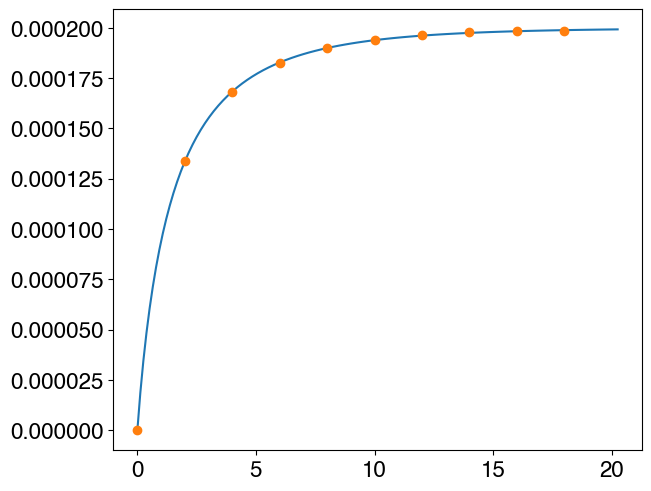

In [24]:
all_times = model_estimate.time_params.times

obs_values = np.zeros((len(observation_locations), obs_times_in_s.size))

for count, ix in enumerate(observation_locations):
    # interpolate the values
    obs_values[count] = (
        sp.interpolate.interp1d(
            all_times, model_reference.tr_model.conc[ix, 0, :], kind="cubic"
        )(obs_times_in_s)
        + obs_noise[count, :]
    )

count = 2

ix = observation_locations[count]
plt.plot(all_times / 3600 / 24, model_reference.tr_model.conc[ix, 0, :])
plt.plot(
    obs_times_in_s / 3600 / 24,
    obs_values[count],
    marker="o",
    linestyle="none",
)

### Demonstrator


- Check the correctness of the gradient

In [25]:
param = pyrtid.inverse.AdjustableParameter(
    name=pyrtid.inverse.ParameterName.DIFFUSION,
    lbounds=1e-10,
    ubounds=1e-1,
    preconditioner=dminv.LogTransform(),
)

observables = []
for i, node_id in enumerate(observation_locations):
    # Careful not to forget the x2
    observables.append(
        pyrtid.inverse.Observable(
            state_variable=pyrtid.inverse.StateVariable.CONCENTRATION,
            node_indices=node_id,
            times=obs_times_in_s,
            values=obs_values[i],
            uncertainties=noise_std,
            sp=0,
        )
    )

# Add diffusion observations in two places
sampled_nodes = [3, 12]
for node in sampled_nodes:
    ix, iy, iz = node_number_to_indices(node)
    observables.append(
        pyrtid.inverse.Observable(
            state_variable=pyrtid.inverse.StateVariable.DIFFUSION,
            node_indices=node,
            times=np.zeros(1),
            values=model_reference.tr_model.diffusion[ix, iy],
            uncertainties=float(np.min(diffusion_reference) * 0.1),
        )
    )

# Create an executor to keep track of the adjoint model
solver_config = pyrtid.inverse.ScipySolverConfig(
    solver_name="L-BFGS-B",
    solver_options={"maxfun": 20, "maxiter": 20, "ftol": 1e-4, "gtol": 1e-4},
    is_check_gradient=False,
    is_adj_numerical_acceleration=True,
    afpi_eps=1e-12,
)
model_adjusted = copy.deepcopy(model_estimate)
inverse_model = pyrtid.inverse.InverseModel(param, observables)
executor = pyrtid.inverse.ScipyInversionExecutor(
    model_adjusted, inverse_model, solver_config
)

# Compute a first objective function
executor.eval_loss(param.preconditioner(param.values.ravel("F")))

is_grad_ok = executor.is_adjoint_gradient_correct(max_workers=6, is_verbose=False)

INFO:root:- Running forward model # 1
INFO:root:- Run # 1 over
INFO:root:Loss (obs fit)        = 103726.68525070672
INFO:root:Loss (obs fit) / Nobs = 1994.7439471289754
INFO:root:Loss (weighted reg)   = 0.0
INFO:root:Total loss            = 103726.68525070672
INFO:root:Scaling factor        = 9.640720684200083e-06
INFO:root:Loss (scaled)         = 1.0



In [26]:
logging.info(f"Is the gradient correct: {is_grad_ok}")

INFO:root:Is the gradient correct: True


In [27]:
param.grad_adj_history[0] / param.grad_fd_history[0]

array([0.99999999, 1.00000001, 0.99999999, 1.        , 1.        ,
       1.00000001, 0.99999996, 1.00000001, 1.00000008, 0.99999998,
       1.        , 1.00000001, 1.00000002, 1.00000002, 0.99999998,
       1.00000003, 0.99999993, 0.99999997, 1.00000124, 1.00000362])

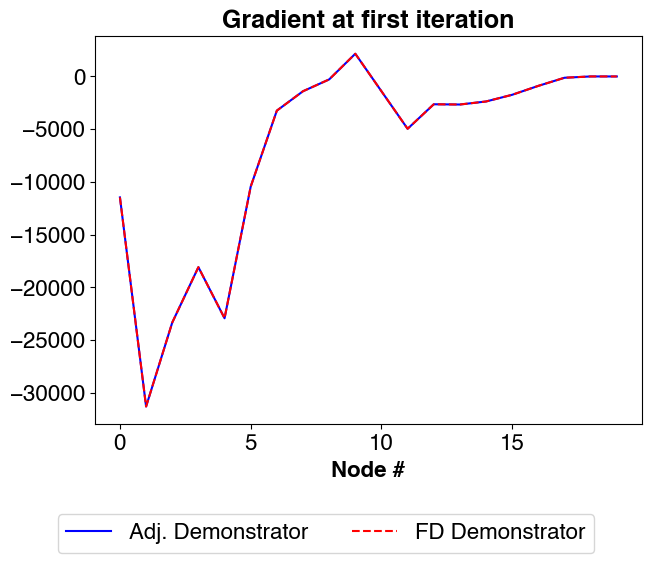

In [28]:
# Here comes the python code
plotter = ngp.NestedGridPlotter()

ax = plotter.get_axis("ax1-1")
ax.plot(
    param.grad_adj_history[0],
    label="Adj. Demonstrator",
    c="b",
)
ax.plot(
    param.grad_fd_history[0],
    label="FD Demonstrator",
    c="r",
    linestyle="--",
)
# ax.plot(hytec_adjoint_gradient["value"], label="Adj. HYTEC", c="g")
# ax.plot(hytec_fd_gradient["value"], label="FD HYTEC", c="k", linestyle="--")

ax.set_title("Gradient at first iteration")
ax.set_xlabel("Node #")
plotter.add_fig_legend(ncol=2, bbox_y_shift=-0.1)

fname = "gradient_dem_vs_hytec_adj_vs_df_1d_diffusion"
for format in ["png", "pdf"]:
    plotter.savefig(fig_save_path.joinpath(f"{fname}.{format}"), format=format)

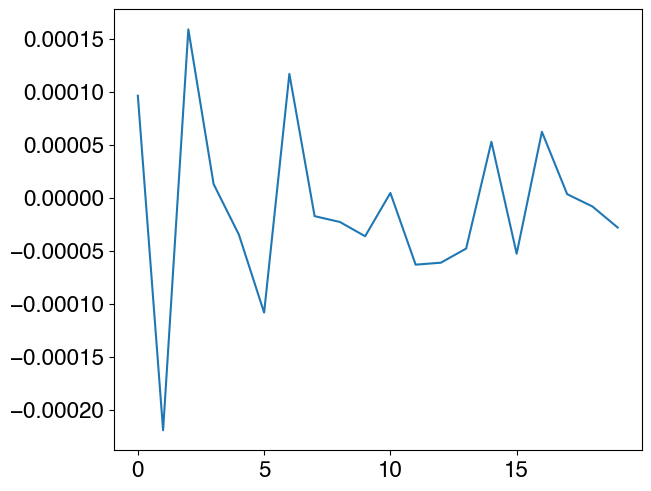

In [29]:
plt.plot((param.grad_adj_history[0] - param.grad_fd_history[0]))

In [30]:
np.count_nonzero(executor.adj_model.a_tr_model.a_mob[1])

1680

In [31]:
param.grad_adj_history[0] / param.grad_fd_history[0]

array([0.99999999, 1.00000001, 0.99999999, 1.        , 1.        ,
       1.00000001, 0.99999996, 1.00000001, 1.00000008, 0.99999998,
       1.        , 1.00000001, 1.00000002, 1.00000002, 0.99999998,
       1.00000003, 0.99999993, 0.99999997, 1.00000124, 1.00000362])

- The adjoint concentrations should be quite the same both in shape and intensity.

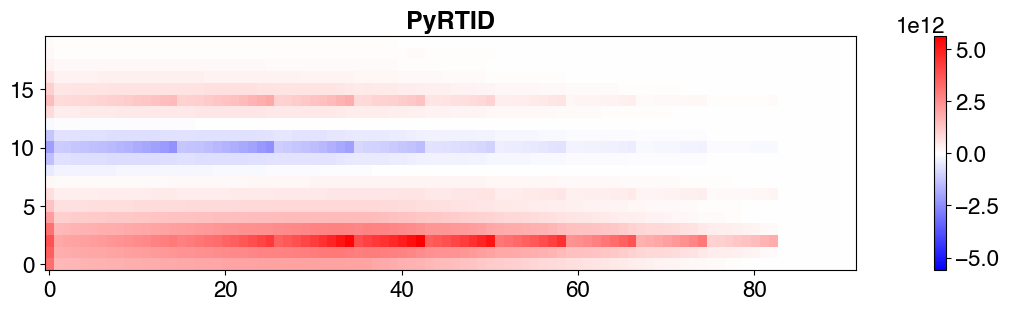

In [32]:
plotter = ngp.NestedGridPlotter(
    plt.figure(constrained_layout=True, figsize=(10, 3)),
    builder=ngp.SubplotsMosaicBuilder(mosaic=[["ax1-1"]], sharey=True, sharex=True),
)

ngp.multi_imshow(
    axes=list(plotter.ax_dict.values()),
    fig=plotter.fig,
    data={
        "PyRTID": executor.adj_model.a_tr_model.a_conc[0, :, 0, :].T,
    },
    is_symmetric_cbar=True,
)

fname = "adjoint_concentrations_dem_vs_hytec_map"
for format in ["png", "pdf"]:
    plotter.savefig(fig_save_path.joinpath(f"{fname}.{format}"), format=format)

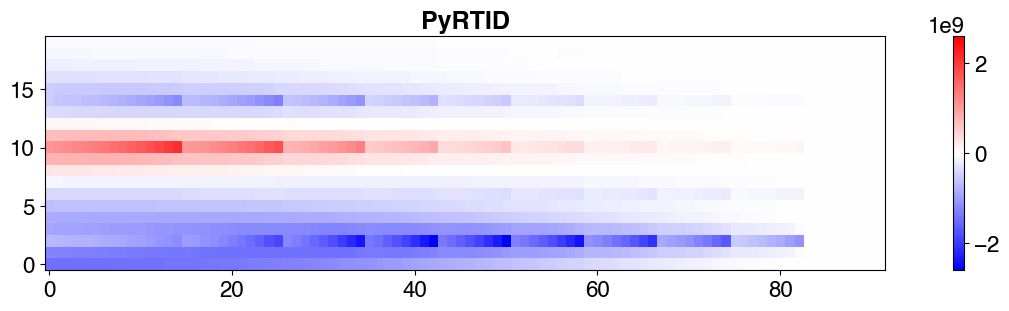

In [33]:
plotter = ngp.NestedGridPlotter(
    plt.figure(constrained_layout=True, figsize=(10, 3)),
    builder=ngp.SubplotsMosaicBuilder(mosaic=[["ax1-1"]], sharey=True, sharex=True),
)

ngp.multi_imshow(
    axes=list(plotter.ax_dict.values()),
    fig=plotter.fig,
    data={
        "PyRTID": executor.adj_model.a_tr_model.a_grade[0, :, 0, :].T,
    },
    is_symmetric_cbar=True,
)

fname = "adjoint_concentrations_dem_vs_hytec_map"
for format in ["png", "pdf"]:
    plotter.savefig(fig_save_path.joinpath(f"{fname}.{format}"), format=format)

- Check the adjoint variables at the observation well

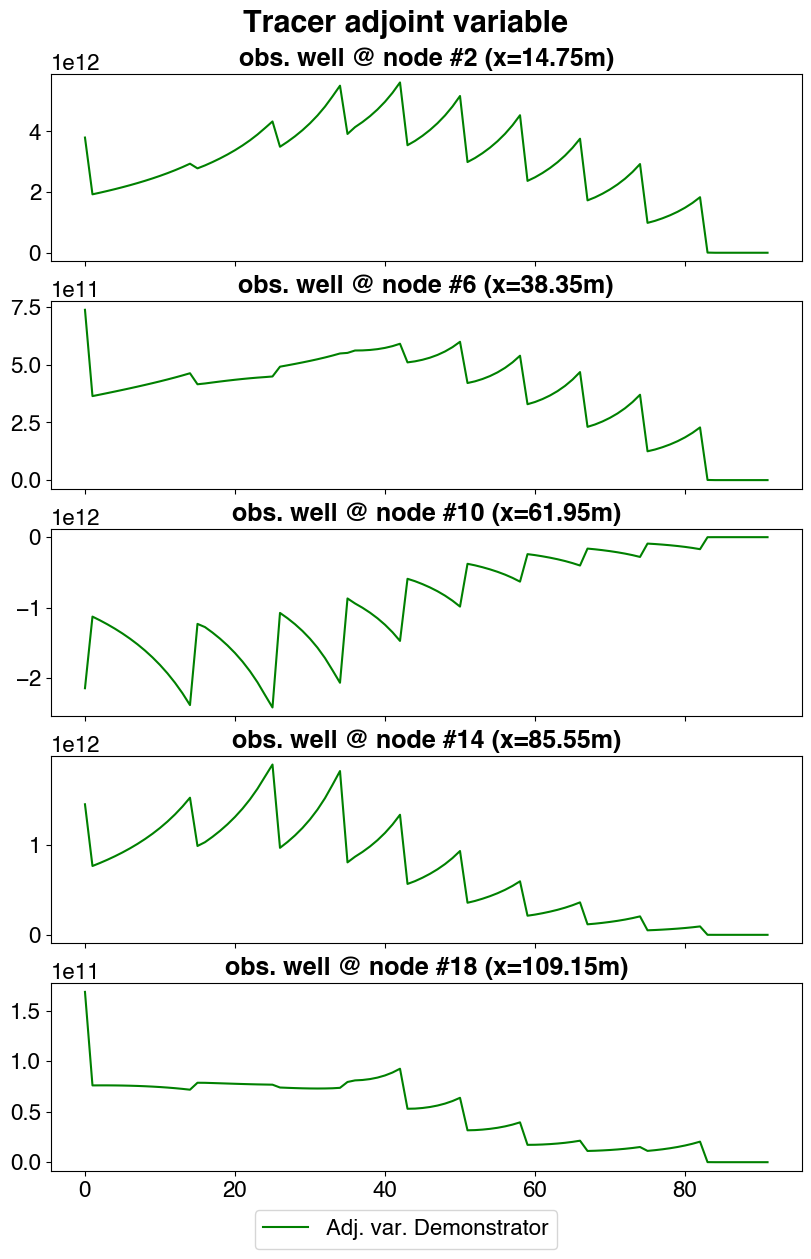

In [34]:
plotter = ngp.NestedGridPlotter(
    plt.figure(constrained_layout=True, figsize=(8, 12)),
    builder=ngp.SubplotsMosaicBuilder(
        mosaic=[["ax1-1"], ["ax2-1"], ["ax3-1"], ["ax4-1"], ["ax5-1"]],
        sharey=False,
        sharex=True,
    ),
)

for i, node_id in enumerate(observation_locations):
    ax = plotter.get_axis(f"ax{i + 1}-1")
    x = (node_id + 0.5) * geometry.dx
    obs_well_name = f"obs. well @ node #{node_id} (x={x:.2f}m)"

    ax.set_title(obs_well_name)
    ax.plot(
        executor.adj_model.a_tr_model.a_conc[0, node_id, 0, :],
        label="Adj. var. Demonstrator",
        c="g",
    )

plotter.fig.suptitle("Tracer adjoint variable", fontweight="bold")
plotter.add_fig_legend(ncol=2, bbox_y_shift=-0.02)

fname = "adjoint_concentrations_dem_vs_hytec_1D"
for format in ["png", "pdf"]:
    plotter.savefig(fig_save_path.joinpath(f"{fname}.{format}"), format=format)